# **Projeto Híbrido - Redes Neurais Não-Supervisionadas (SOM) + Redes Supervisionadas (ANN - MLP)**

**Objetivo**: desenvolver um projeto para identificação de transações fraudulentas por meio de um conjunto de dados de transações de cartão de crédito.

- primeiro utilizamos redes neurais não-supervisionadas (SOM) para identificar transações "anômalas" por meio da métrica de distância média interneurons
- segundo, vamos utilizar as transações anômalas para treinar uma rede neural classificadora (MLP) para prever as pessoas com maior possibilidade de fraude.

In [1]:
!pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=c1c890563ad7ee63b6c142b55fcac9d2be7f960936d1d5b9246ce14f27346de0
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built MiniSom


In [30]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from minisom import MiniSom
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from pylab import bone, pcolor, colorbar, plot, show

# ignorar warnings
warnings.filterwarnings('ignore')

In [3]:
# montar drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# realizar a leitura dos dados
FILE_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/DeepLearningTensorflow/'+\
            'data/Credit_Card_Applications.csv'
data = pd.read_csv(FILE_PATH)
data.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


## Treinamento do SOM e identificação das fraudes

In [5]:
# separar entre x e y
x = data.drop(columns=['CustomerID', 'Class'])
y = data[['Class']]

In [6]:
# normalizando os dados de entrada
scaler = MinMaxScaler(feature_range=(0, 1))

x_norm = scaler.fit_transform(x)

In [19]:
# treinar o SOM - Self Organizing Maps
som = MiniSom(x=11, y=12, sigma=1.5, input_len=x_norm.shape[1], learning_rate=0.1)
som.random_weights_init(x_norm)
som.train_random(data=x_norm, num_iteration=200)

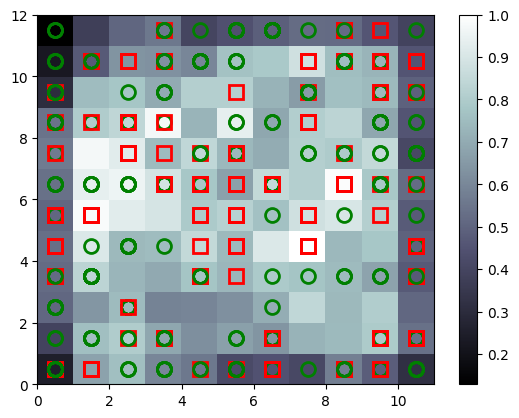

In [20]:
# visualizar os resultados
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['g', 'r']
for i, sample in enumerate(x_norm):

  # obter a posição do neurônio vencedor
  w = som.winner(sample)
  plot(
      w[0] + 0.5,
      w[1] + 0.5,
      markers[y.loc[i, 'Class']],
      markeredgecolor=colors[y.loc[i, 'Class']],
      markerfacecolor='None',
      markersize=10,
      markeredgewidth=2
  )

In [21]:
# identificação das potenciais fraudes
mappings = som.win_map(x_norm) # mapeamento de todos os neurônios vencedores para
                               # cada uma das linhas dos dados

# obter as distâncias médias interneurons de cada neurônio
distances = som.distance_map()
distances

# correlacionar distâncias com as coordenadas dos neurônios
# de potenciais anomalias
THRESHOLD = 0.8
dist_map = {}

for i in range(distances.shape[0]):
  for j in range(distances.shape[1]):
    if distances[i, j] >= THRESHOLD:
      dist_map[f'{i}-{j}'] = {}
      dist_map[f'{i}-{j}']['coord'] = (i, j)
      dist_map[f'{i}-{j}']['distance'] = distances[i, j]

In [22]:
# concatenar arrays das fraudes
fraudes = []
for f in dist_map:
  if len(mappings[dist_map[f]['coord']]) != 0:
    fraudes.append(mappings[dist_map[f]['coord']])

# juntando tudo num dataset
fraudes = np.concatenate(fraudes, axis=0)

# voltando às variáveis originais
fraudes = pd.DataFrame(scaler.inverse_transform(fraudes), columns=x.columns)

In [23]:
fraudes

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,0.0,23.75,0.710,2.0,9.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,240.0,5.0
1,0.0,17.33,9.500,2.0,6.0,4.0,1.750,0.0,1.0,10.0,1.0,2.0,0.0,11.0
2,0.0,16.92,0.500,2.0,3.0,4.0,0.165,0.0,1.0,6.0,1.0,2.0,240.0,36.0
3,0.0,16.00,0.165,2.0,6.0,4.0,1.000,0.0,1.0,2.0,1.0,2.0,320.0,2.0
4,0.0,28.58,3.750,2.0,8.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,40.0,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1.0,65.42,11.000,2.0,10.0,9.0,20.000,1.0,1.0,7.0,1.0,2.0,22.0,1.0
142,1.0,67.75,5.500,2.0,10.0,9.0,13.000,1.0,1.0,1.0,1.0,2.0,0.0,1.0
143,1.0,22.67,2.540,1.0,8.0,8.0,2.585,1.0,0.0,0.0,0.0,2.0,0.0,1.0
144,1.0,51.83,3.000,1.0,1.0,1.0,1.500,0.0,0.0,0.0,0.0,2.0,180.0,5.0


- agora que aplicamos o SOM para identificar as potenciais anomalias, precisamos correlacionar quais são as classes reais de cada linha das potenciais anomalias. Faremos isso com uma "chave" de ligação.

In [24]:
# a chave vai ser a concatenação de todos atributos na forma de texto.

# arrendondar os valores para uma precisão aceitável e concatenar todas
# as colunas
fraudes = fraudes.round(12)
fraudes['key'] = fraudes.apply(lambda row: ''.join(map(str, row)), axis=1)
fraudes

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,key
0,0.0,23.75,0.710,2.0,9.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,240.0,5.0,0.023.750.712.09.04.00.250.01.01.01.02.0240.05.0
1,0.0,17.33,9.500,2.0,6.0,4.0,1.750,0.0,1.0,10.0,1.0,2.0,0.0,11.0,0.017.339.52.06.04.01.750.01.010.01.02.00.011.0
2,0.0,16.92,0.500,2.0,3.0,4.0,0.165,0.0,1.0,6.0,1.0,2.0,240.0,36.0,0.016.920.52.03.04.00.1650.01.06.01.02.0240.036.0
3,0.0,16.00,0.165,2.0,6.0,4.0,1.000,0.0,1.0,2.0,1.0,2.0,320.0,2.0,0.016.00.1652.06.04.01.00.01.02.01.02.0320.02.0
4,0.0,28.58,3.750,2.0,8.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,40.0,155.0,0.028.583.752.08.04.00.250.01.01.01.02.040.0155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1.0,65.42,11.000,2.0,10.0,9.0,20.000,1.0,1.0,7.0,1.0,2.0,22.0,1.0,1.065.4211.02.010.09.020.01.01.07.01.02.022.01.0
142,1.0,67.75,5.500,2.0,10.0,9.0,13.000,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.067.755.52.010.09.013.01.01.01.01.02.00.01.0
143,1.0,22.67,2.540,1.0,8.0,8.0,2.585,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.022.672.541.08.08.02.5851.00.00.00.02.00.01.0
144,1.0,51.83,3.000,1.0,1.0,1.0,1.500,0.0,0.0,0.0,0.0,2.0,180.0,5.0,1.051.833.01.01.01.01.50.00.00.00.02.0180.05.0


In [25]:
# arrendondar os valores para uma precisão aceitável e concatenar todas
# as colunas
data[x.columns] = data[x.columns].round(12)
data['key'] = data[x.columns].apply(lambda row: ''.join(map(str, row)), axis=1)
data

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class,key
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0,1.022.0811.462.04.04.01.5850.00.00.01.02.0100....
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0,0.022.677.02.08.04.00.1650.00.00.00.02.0160.01.0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0,0.029.581.751.04.04.01.250.00.00.01.02.0280.01.0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1,0.021.6711.51.05.03.00.01.01.011.01.02.00.01.0
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1,1.020.178.172.06.04.01.961.01.014.00.02.060.01...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1,1.031.5710.52.014.04.06.51.00.00.00.02.00.01.0
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0,1.020.670.4152.08.04.00.1250.00.00.00.02.00.045.0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1,0.018.839.542.06.04.00.0851.00.00.00.02.0100.01.0
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1,0.027.4214.52.014.08.03.0851.01.01.00.02.0120....


In [26]:
# criando o conjunto de dados para modelagem final
data_model = pd.merge(left=fraudes, left_on=['key'], right=data[['key', 'Class']], right_on=['key'], how='left')
data_model.drop(columns=['key'], inplace=True)
data_model.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,0.0,23.75,0.710,2.0,9.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,240.0,5.0,0.0
1,0.0,17.33,9.500,2.0,6.0,4.0,1.750,0.0,1.0,10.0,1.0,2.0,0.0,11.0,0.0
2,0.0,16.92,0.500,2.0,3.0,4.0,0.165,0.0,1.0,6.0,1.0,2.0,240.0,36.0,0.0
3,0.0,16.00,0.165,2.0,6.0,4.0,1.000,0.0,1.0,2.0,1.0,2.0,320.0,2.0,0.0
4,0.0,28.58,3.750,2.0,8.0,4.0,0.250,0.0,1.0,1.0,1.0,2.0,40.0,155.0,0.0


## Treinamento do Preditor e Previsão das Fraudes

### Breve Análise Exploratória

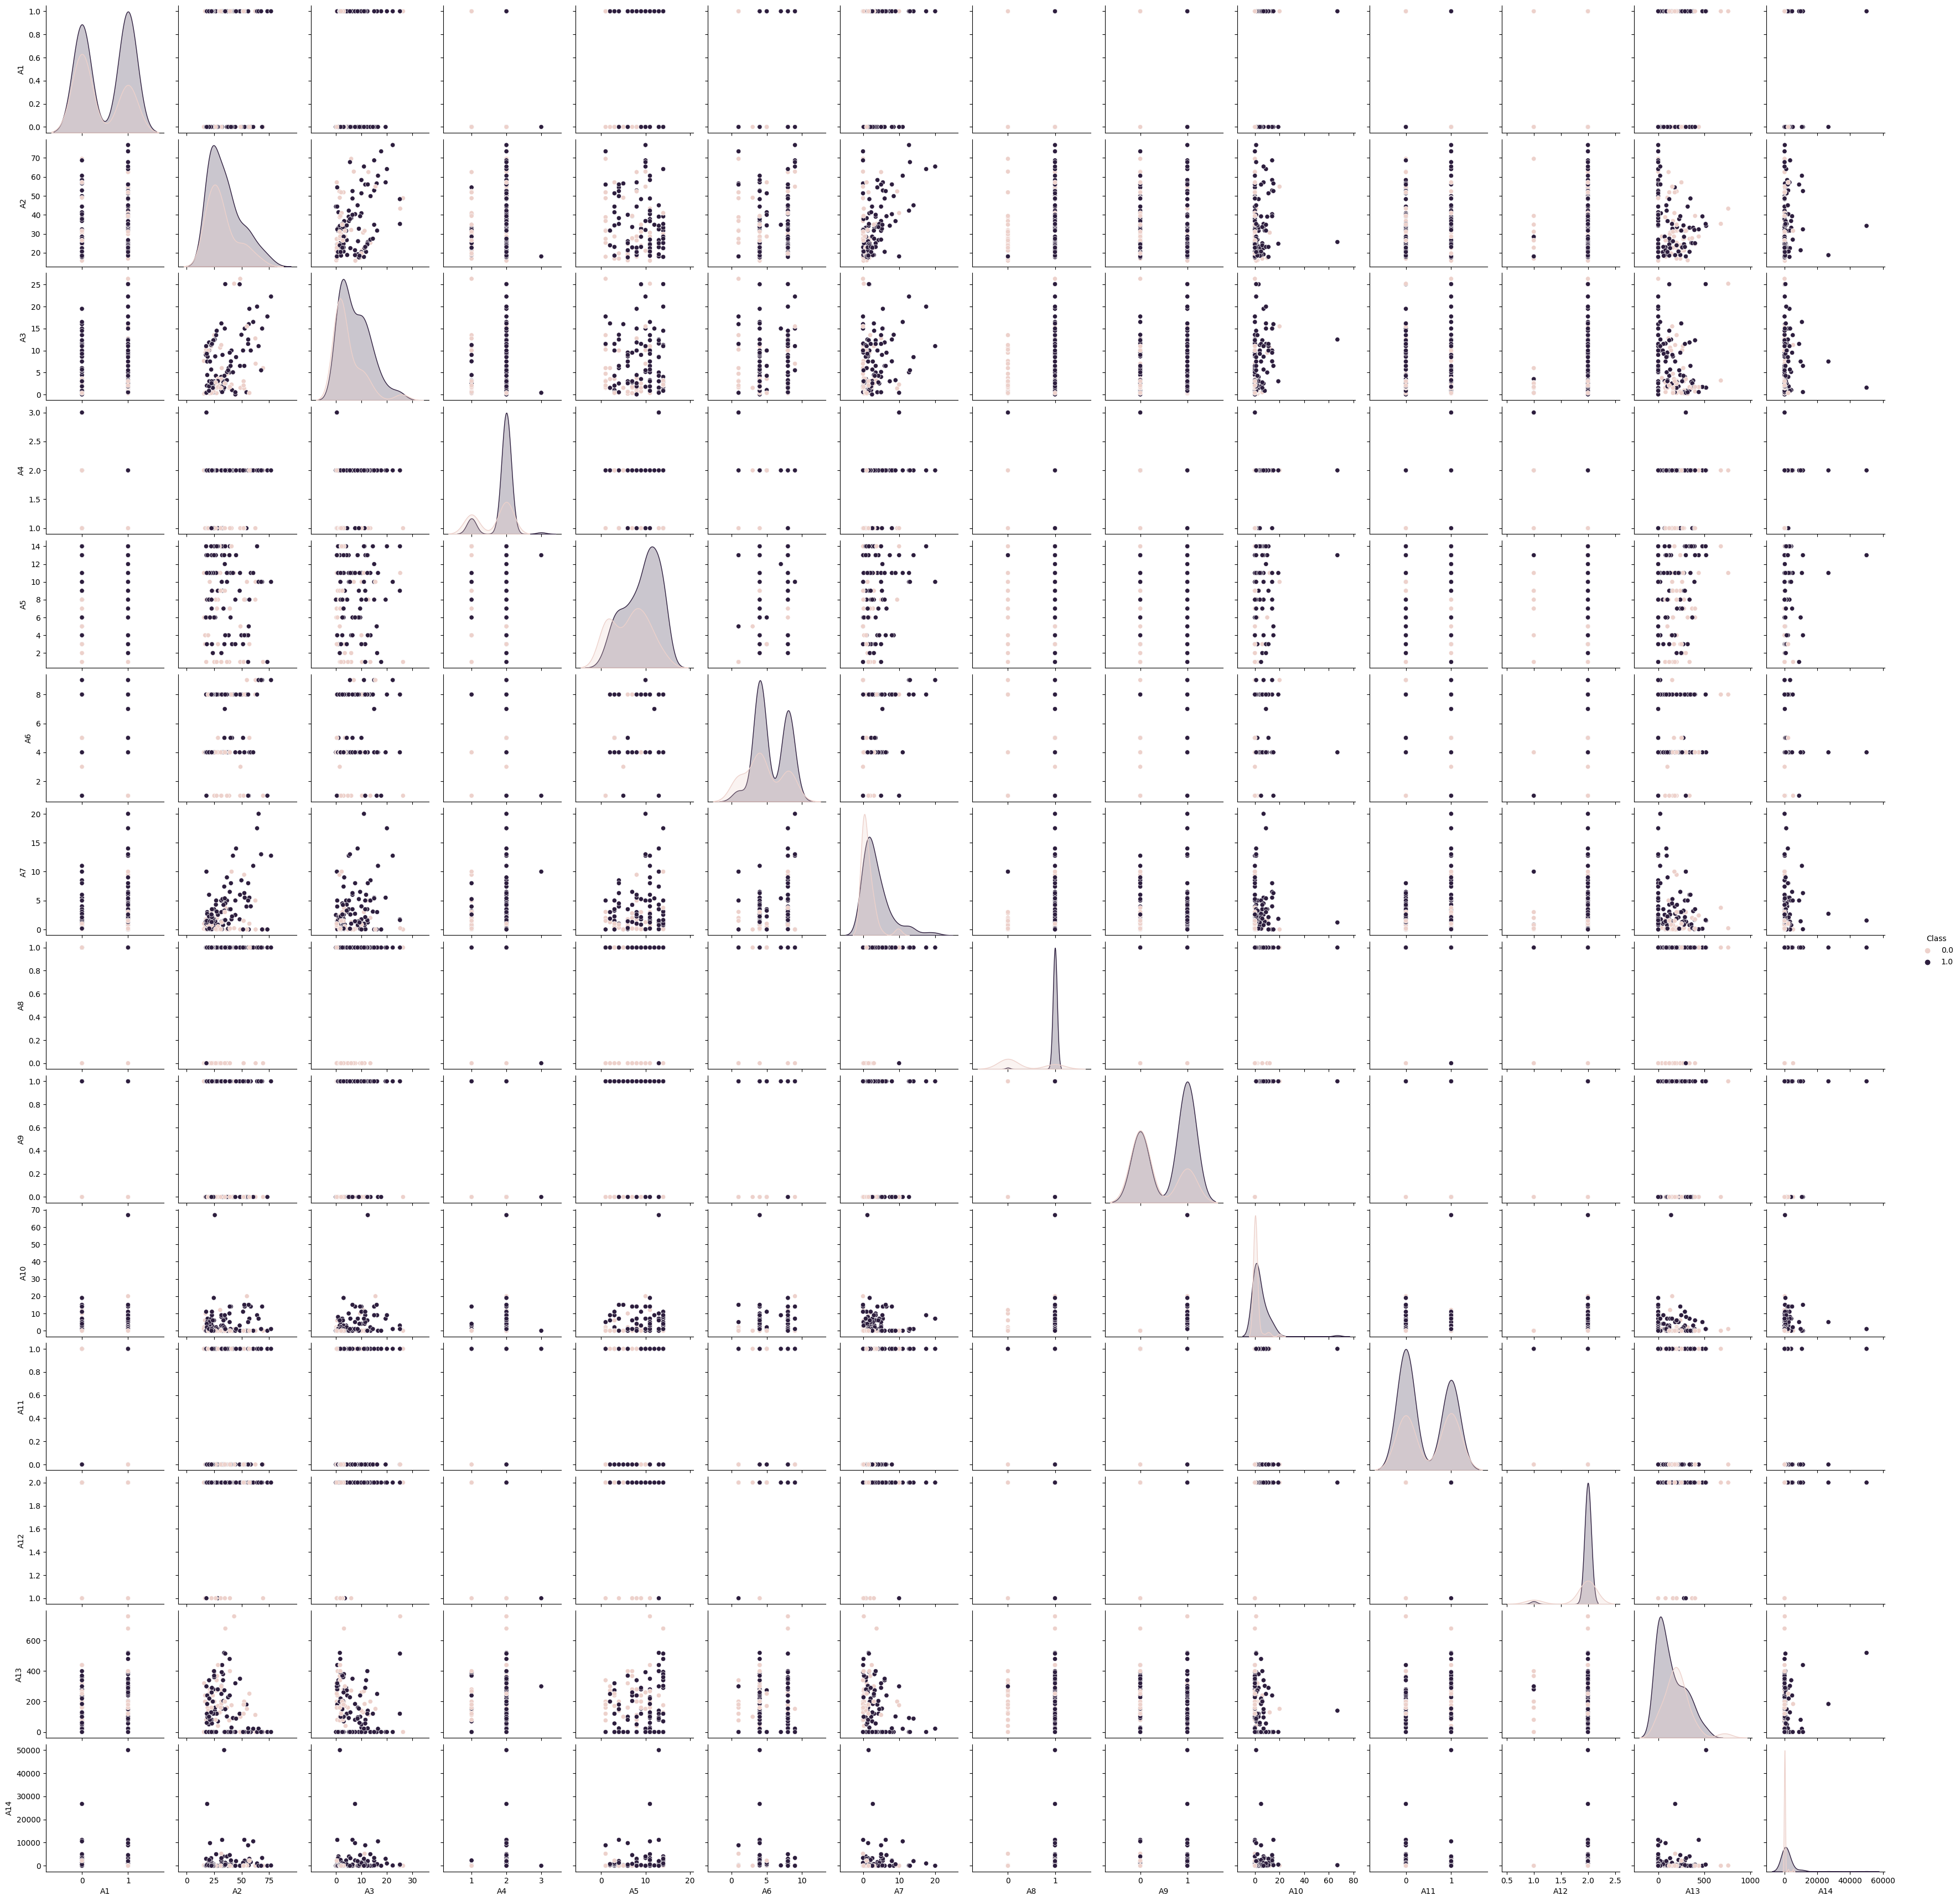

In [27]:
# análise exploratória
sns.pairplot(data_model, hue='Class')

In [28]:
# balanceamento das classes
data_model['Class'].value_counts()

1.0    89
0.0    53
Name: Class, dtype: int64

In [29]:
data['Class'].value_counts()

0    383
1    307
Name: Class, dtype: int64

In [31]:
# classe para o pre-processamento
class PreProcessing:

  def __init__(self) -> None:
    pass

  @staticmethod
  def split_train_val_test(x, y) -> list:

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

    return x_train, x_test, y_train, y_test

  @staticmethod
  def feature_scaling(x_train, x_test) -> list:

    # criando o scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # ajustar o scaler
    scaler.fit(x_train)

    # transformar os dados
    x_train_norm = scaler.transform(x_train)
    x_test_norm = scaler.transform(x_test)

    return x_train_norm, x_test_norm

In [35]:
# excutando a classe de preprocessamento
pp = PreProcessing()

# separando entre x e y
data_model.dropna(inplace=True)
x = data_model.drop(columns=['Class'])
y = data_model[['Class']]

In [37]:
# realizando o preprocessamento
data_list = pp.split_train_val_test(x=x, y=y)
x_train, x_test, y_train, y_test = data_list[0], data_list[1], data_list[2], data_list[3]

x_train_norm, x_test_norm = pp.feature_scaling(x_train=x_train, x_test=x_test)

In [58]:
# classe para redes neurais
class NeuralNetworks:

  # definir constantes
  ACT_HIDDEN = 'relu'
  ACT_OUTPUT = 'sigmoid'
  OPTIMIZER = 'adam'
  METRICS = ['F1Score']

  def __init__(self, loss_name) -> None:
    self.LOSS = loss_name

  def create_model(self, x, n_neurons_list) -> None:

    # salvar lista neurons
    self.n_neurons = n_neurons_list

    # definir o modelo sequencial
    self.model = Sequential()

    if len(n_neurons_list) == 1:
      self.model.add(
          Dense(n_neurons_list[0],
                input_shape=(x.shape[1],),
                activation=self.ACT_HIDDEN))
    else:
      for n in n_neurons_list:
        if n == n_neurons_list[0]:
          self.model.add(
              Dense(n,
                    input_shape=(x.shape[1], ),
                    activation=self.ACT_HIDDEN)
          )
        else:
          self.model.add(
              Dense(
                  n,
                  activation=self.ACT_HIDDEN
              )
          )

    # adicionar a camada de saída
    self.model.add(Dense(1, activation=self.ACT_OUTPUT))

  def fit_model(self, x, y, n_epochs, batch_size):

    # armazenar entradas como atributos
    self.N_EPOCHS = n_epochs
    self.BATCH_SIZE = batch_size

    # compilar o modelo
    self.model.compile(loss=self.LOSS,
                       optimizer=self.OPTIMIZER,
                       metrics=self.METRICS)

    # treinar o modelo
    self.history = self.model.fit(
        x,
        y,
        epochs=self.N_EPOCHS,
        batch_size=self.BATCH_SIZE
    )

  def plot_history(self):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['f1_score'], label='Treinamento')
    plt.xlabel('Número de Épocas')
    plt.ylabel(self.METRICS[0])
    plt.title(f'Curva de Aprendizado - {self.METRICS[0]}')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['loss'], label='Treinamento')
    plt.legend(loc='best')
    plt.xlabel('Número de Épocas')
    plt.ylabel('Função de Perda')
    plt.title('Curva de Aprendizado - Função de Perda')
    plt.show()

In [78]:
# testando nossa rede neural para classificar fraudes
loss = 'binary_crossentropy'
nn = NeuralNetworks(loss_name=loss)
nn.create_model(x=x_train_norm, n_neurons_list=[5, 5])

# analisando o modelo criado
print(nn.model.summary())

# treinamento do model
nn.fit_model(x=x_train_norm, y=y_train, n_epochs=100, batch_size=20)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 5)                 75        
                                                                 
 dense_31 (Dense)            (None, 5)                 30        
                                                                 
 dense_32 (Dense)            (None, 1)                 6         
                                                                 
Total params: 111 (444.00 Byte)
Trainable params: 111 (444.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
6/6 [==============================] - 1s 8ms/step - loss: 0.7675 - f1_score: 0.7717
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.7502 - f1_score: 0.7717
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.7355 -

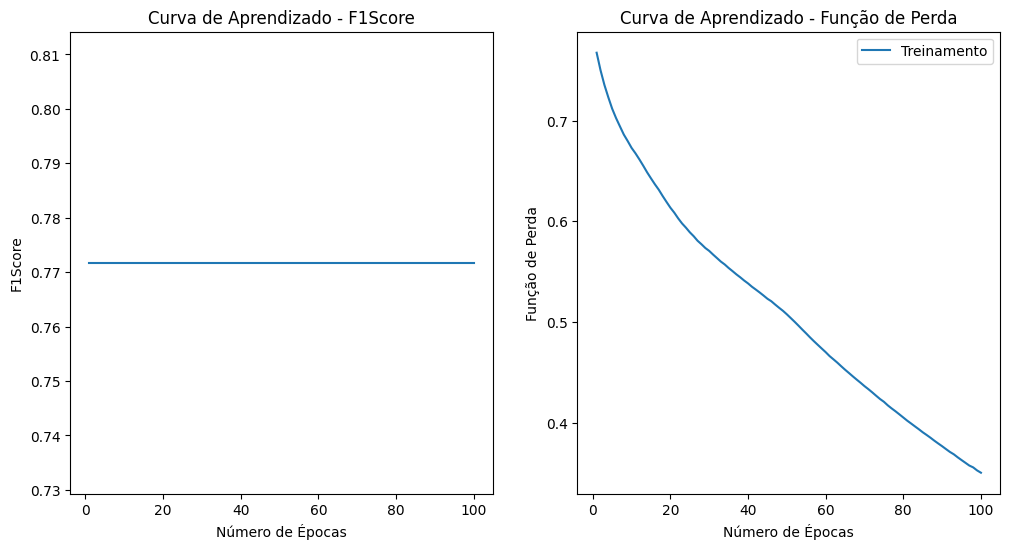

In [79]:
# analisando a curva de aprendizado
nn.plot_history()

In [80]:
# validação na base de teste
yhat_train = nn.model.predict(x_train_norm)
yhat_test = nn.model.predict(x_test_norm)

# transformação para classes
yhat_train = [1 if x > 0.5 else 0 for x in yhat_train]
yhat_test = [1 if x > 0.5 else 0 for x in yhat_test]

1/1 [==============================] - 0s 25ms/step


In [81]:
# analisando o desempenho da rede - Base de Treinamento
print(classification_report(y_train, yhat_train))

              precision    recall  f1-score   support

         0.0       0.93      0.67      0.78        42
         1.0       0.83      0.97      0.90        71

    accuracy                           0.86       113
   macro avg       0.88      0.82      0.84       113
weighted avg       0.87      0.86      0.85       113



In [82]:
# analisando o desempenho da rede - Base de Teste
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84        11
         1.0       0.86      1.00      0.92        18

    accuracy                           0.90        29
   macro avg       0.93      0.86      0.88        29
weighted avg       0.91      0.90      0.89        29

